In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

from scipy.stats import linregress
from scipy.stats import mannwhitneyu
from scipy.stats import ks_2samp
from scipy.stats import rankdata

import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
PROTEINS = [
    "5P",
    "NSP1",
    "NSP2",
    "NSP3",
    "NSP4",
    "NSP5",
    "NSP6",
    "NSP7",
    "NSP8",
    "NSP9",
    "NSP10",
    "NSP11",
    "NSP12",
    "NSP13",
    "NSP14",
    "NSP15",
    "NSP16",
    "Spike",
    "NS3",
    "E",
    "M",
    "NS6",
    "NS7a",
    "NS7b",
    "NS8",
    "N",
    "NS9b",
    "NS9c",
    "3P",
    "RNA"
]

ANNOTATION = {
    "5P": "1-265",
    "NSP1": "266-805",
    "NSP2": "806-2719",
    "NSP3": "2720-8554",
    "NSP4": "8555-10054",
    "NSP5": "10055-10972",
    "NSP6": "10973-11842",
    "NSP7": "11843-12091",
    "NSP8": "12092-12685",
    "NSP9": "12686-13024",
    "NSP10": "13025-13441",
    "NSP11": "13442-13480",
    # "NSP12": "13442-13468",
    "NSP12": "13468-16236",
    "NSP13": "16237-18039",
    "NSP14": "18040-19620",
    "NSP15": "19621-20658",
    "NSP16": "20659-21552",
    "Spike": "21563-25384",
    "NS3": "25393-26220",
    "E": "26245-26472",
    "M": "26523-27191",
    "NS6": "27202-27387",
    "NS7a": "27394-27759",
    "NS7b": "27756-27887",
    "NS8": "27894-28259",
    "N": "28274-29533",
    "NS9b": "28284-28577",
    "NS9c": "28734-28955",
    "3P": "29534-30331"
}

In [3]:
def read_fasta(path):
    result = ""
    description = ""

    ff = open(path, "r")

    line = next(ff, None)
    while line:
        line = line.rstrip("\n")
        if not line:
            line = next(ff, None)
            continue

        if line.startswith(">"):
            if result:
                yield description, result
            description = line.lstrip(">")
            result = ""
        else:
            result += line

        line = next(ff, None)

    yield description, result
    ff.close()
    
def percent(seq, chr="N"):
    count = 0
    for char in seq:
        if char == chr:
            count += 1
    return count / len(seq)

def region_count(reg, start=None, end=None):
    reg = reg.lstrip("[").rstrip("]").split(", ")
    if not (start is None) and not (end is None):
        reg = [s for s in reg if s and (start <= int(s) <= end)]
    else:
        reg = [s for s in reg if s]
    return len(reg)

In [4]:
# meta preparation

In [ ]:
meta_df = pd.read_csv(
    "../../gisaid/germany_ber_meta.csv",
    sep=",", index_col=0)

rna_df = pd.DataFrame(columns=["strain", "length", "polyA", "percN"])
tqdrator = tqdm.tqdm(read_fasta("../../gisaid/germany_ber.fasta"), total=24778)
for covid, rna in tqdrator:
    length = len(rna)
    perc = percent(rna, "N")
    poly = len(rna) - len(rna.rstrip("A"))
    append_df = pd.DataFrame(
        columns=rna_df.columns.to_list(),
        data=[[
            covid,
            length,
            poly,
            perc
        ]]
    )
    rna_df = pd.concat([rna_df, append_df], ignore_index=True)

rna_df.index = rna_df["strain"]
rna_df = rna_df.drop(columns=["strain"])
meta_df = meta_df.join(rna_df, how="inner")

meta_df["date"] = meta_df.index.str.split("|").str[1]
meta_df["date"] = pd.to_datetime(meta_df["date"], format="%Y-%m-%d")
meta_df = meta_df.sort_values(by=["date"])

meta_df["date"] = meta_df.index.str.split("|").str[1]
meta_df["date"] = pd.to_datetime(meta_df["date"], format="%Y-%m-%d")
meta_df = meta_df.sort_values(by=["date"])

meta_df = meta_df.loc[meta_df["date"].astype("str").apply(lambda dt: len(dt.split("-"))) == 3]
meta_df["year"] = meta_df["date"].astype("str").str.split("-").str[0].astype("int")
meta_df["month"] = meta_df["date"].astype("str").str.split("-").str[1].astype("int")
meta_df["day"] = meta_df["date"].astype("str").str.split("-").str[2].astype("int")
meta_df["days"] = meta_df["day"] + meta_df["month"] * 30 + meta_df["year"] * 365
start = int(meta_df.iloc[0]["days"])
meta_df["days"] -= start
meta_df = meta_df.drop(columns=["year", "month", "day"])

  1%|▏         | 340/24778 [00:03<04:43, 86.05it/s]

In [33]:
# Meta description

3342
3342


<AxesSubplot:xlabel='days', ylabel='percN'>

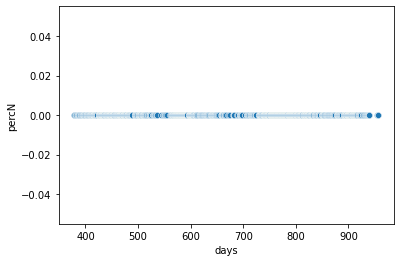

In [34]:
print(len(
    meta_df.loc[
        meta_df["percN"] == 0.
    ]
))
print(len(
    meta_df.loc[
        meta_df["percN"] < 0.001
    ]
))

sns.scatterplot(
    y="percN",
    x="days",
    data=meta_df.loc[
        meta_df["percN"] < 0.001
    ]
)

<AxesSubplot:xlabel='days', ylabel='Count'>

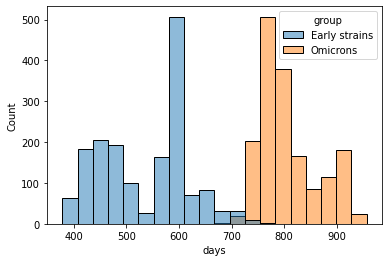

In [35]:
plot_df = meta_df.copy()
plot_df = plot_df.loc[
    (~plot_df["scorpio_call"].isna()) & \
    (plot_df["percN"] == 0.)
]

plot_df["group"] = "Early strains"
plot_df.loc[
    plot_df["scorpio_call"].str.contains("Omicron"),
    "group"
] = "Omicrons"

sns.histplot(
    x="days",
    hue="group",
    data=plot_df.loc[
        plot_df["percN"] == 0.
    ][["days", "group"]]
)

MannwhitneyuResult(statistic=1377905.5, pvalue=0.5136952566741468)


<AxesSubplot:xlabel='length', ylabel='Count'>

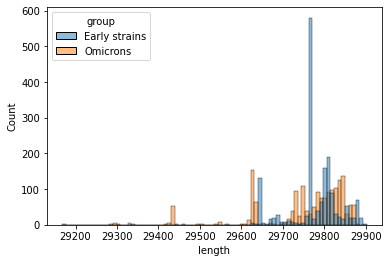

In [36]:
print(mannwhitneyu(
    plot_df.loc[
        plot_df["group"] == "Omicrons",
        "length"].to_list(),
    plot_df.loc[
        plot_df["group"] == "Early strains",
        "length"].to_list()
))

sns.histplot(
    x="length",
    hue="group",
    data=plot_df
)

In [ ]:
# Berlin VOC's description

In [ ]:
df = meta_df.loc[
    (~meta_df["scorpio_call"].isna()) & \
    (meta_df["percN"] == 0.) & \
    (meta_df["length"] > 29000)
]

STRAINS = []
df["strain"] = df.index
STRAINS = df["strain"].to_list()

In [ ]:
STRAINS[:1]

In [ ]:
output = open("germany_ber_vocs.fasta", "w")
for description, seq in read_fasta("../../gisaid/germany_ber.fasta"):
    if description.lstrip(">") in STRAINS:
        output.write(">" + description.lstrip("\n") + "\n")
        output.write(seq + "\n")

In [ ]:
print(meta_df.iloc[0]["date"])
print(meta_df.iloc[-1]["date"])
print(len(meta_df))

In [ ]:
print(meta_df.loc[STRAINS].iloc[0]["date"])
print(meta_df.loc[STRAINS].iloc[-1]["date"])

In [ ]:
meta_df = meta_df.loc[STRAINS]

In [ ]:
print(meta_df["scorpio_call"].value_counts().sum())
meta_df["scorpio_call"].value_counts()

In [ ]:
meta_df.loc[:, "group"] = "first"
meta_df.loc[meta_df["scorpio_call"].str.contains("micron"), "group"] = "second"

In [ ]:
print(meta_df.loc[meta_df.index.isin(STRAINS) & \
    (meta_df["group"] == "first")
][["scorpio_call"]].value_counts().sum())

meta_df.loc[
    meta_df.index.isin(STRAINS) & \
    (meta_df["group"] == "first")
][["scorpio_call"]].value_counts()

In [ ]:
print(meta_df.loc[meta_df.index.isin(STRAINS) & \
    (meta_df["group"] == "second")
][["scorpio_call"]].value_counts().sum())

meta_df.loc[
    meta_df.index.isin(STRAINS) & \
    (meta_df["group"] == "second")
][["scorpio_call"]].value_counts()

/usr/local/lib/python3.8/dist-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


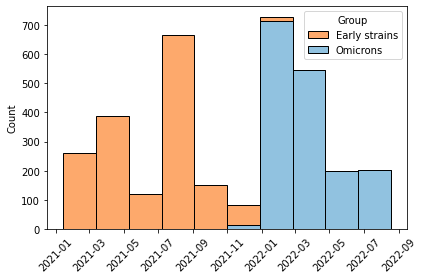

In [37]:
plot_df = meta_df.loc[STRAINS].copy()

plot_df.loc[
    plot_df["group"] == "first",
    "group"
] = "Early strains"

plot_df.loc[
    plot_df["group"] == "second",
    "group"
] = "Omicrons"

plot_df = plot_df.rename(columns={
    "scorpio_call": "Strain",
    "date": "Date",
    "group": "Group"
})

top = mpl.colormaps['Blues_r']
bottom = mpl.colormaps['Oranges']
colors = np.vstack((
    # bottom(np.linspace(0.1, 0.9, 11)),
    # top(np.linspace(0.1, 0.9, 8)),
    bottom(np.linspace(0.5,0.6, 1)),
    top(np.linspace(0.5, 0.6, 1))
))
cmap = ListedColormap(colors, name='OrangeBlue')

sns.histplot(
    x="Date",
    hue="Group",
    multiple="stack",
    data=plot_df,
    bins=10,
    palette=cmap.colors
)
plt.ylabel("Count")
plt.xlabel("")
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig("../../pictures/berlin-strains.png", dpi=500)

MannwhitneyuResult(statistic=1414286.5, pvalue=0.5136952566741468)
29777.693509615383 29757.047079856973


<AxesSubplot:xlabel='length', ylabel='Probability'>

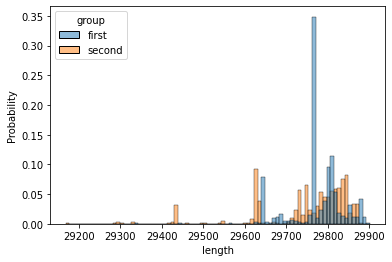

In [38]:
print(mannwhitneyu(
    meta_df.loc[meta_df["group"] == "first"]["length"].to_list(),
    meta_df.loc[meta_df["group"] == "second"]["length"].to_list()
))
print(
    meta_df.loc[meta_df["group"] == "first"]["length"].mean(),
    meta_df.loc[meta_df["group"] == "second"]["length"].mean()
)
# sns.scatterplot(x="length", y="percN", hue="group", alpha=0.5, data=meta_df)
sns.histplot(
    x="length",
    hue="group",
    alpha=0.5,
    data=meta_df,
    stat="probability",
    common_norm=False,
)

In [ ]:
# binding regions

In [ ]:
rdf = pd.read_csv(f"../../results/germany_ber/seed.csv", sep=";", index_col=0)
rdf.index = rdf.index.str.lstrip(">")
rdf["strain"] = rdf.index

# LUAD analysis

In [ ]:
# expressed miRNAs

In [39]:
miRNA_df = pd.read_csv("../../miRNA/expressed_LUAD.csv", sep=",")
miRNA_df.index = miRNA_df["MIMAT"]

TOTAL_EXPRESSION = miRNA_df["CPM"].sum()
MIMATS = miRNA_df["MIMAT"].to_list()

In [47]:
mrdf = rdf.loc[STRAINS][MIMATS]
# mrdf["strain"] = mrdf.index

In [41]:
# region count df

In [48]:
count_df = None

for protein in tqdm.tqdm(PROTEINS):
    df = mrdf.copy()    
    df["region"] = [protein] * len(df)
        
    if protein != "RNA":
        s, e = map(lambda x: int(x) - 1, ANNOTATION[protein].split("-"))
    else:
        s, e = None, None

    for mimat in MIMATS:
        df[mimat] = df[mimat].apply(lambda x: region_count(x, s, e))

    if count_df is None:
        count_df = df
    else:
        count_df = pd.concat([count_df, df], ignore_index=True)

count_df.loc[:, "count"] = 0
count_df.loc[:, "weighted count"] = 0
for mimat in tqdm.tqdm(MIMATS):
    expression = (miRNA_df.loc[mimat, "CPM"] / TOTAL_EXPRESSION)
    count_df["count"] += count_df[mimat]
    count_df["weighted count"] += count_df[mimat] * expression

100%|██████████| 32/32 [00:00<00:00, 297.33it/s]


In [49]:
wcount_df = pd.read_csv("../../results/wuhan/seed.csv", sep=";", index_col=0)

for mimat in MIMATS:
    wcount_df[mimat] = wcount_df[mimat].apply(lambda x: region_count(x))
    
wcount_df.loc[:, "count"] = 0
wcount_df.loc[:, "weighted count"] = 0
for mimat in tqdm.tqdm(MIMATS):
    expression = (miRNA_df.loc[mimat, "CPM"] / TOTAL_EXPRESSION)
    wcount_df["count"] += wcount_df[mimat]
    wcount_df["weighted count"] += wcount_df[mimat] * expression

100%|██████████| 32/32 [00:00<00:00, 732.44it/s]


In [50]:
# average count of binding regions

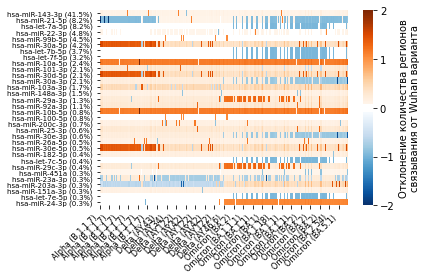

In [67]:
plot_df = count_df.loc[count_df["region"] == "RNA"].copy()

plot_df.index = plot_df["strain"]
plot_df = plot_df[MIMATS]
plot_df = plot_df.join(meta_df[["scorpio_call", "lineage", "length"]], how="left")

for mimat in MIMATS:
    plot_df[mimat] = np.array(plot_df[mimat], dtype=np.float64) * \
        (30331 / np.array(plot_df["length"], dtype=np.float64)) - \
        np.array(wcount_df[mimat], dtype=np.float64)

plot_df["strain"] = plot_df["scorpio_call"].str.split("(").str[0] + "(" + \
    plot_df["lineage"] + ")"
plot_df.index = plot_df["strain"]
plot_df = plot_df[MIMATS]

plot_df = plot_df.transpose()

miRNA_df.index = miRNA_df["MIMAT"]
plot_df = plot_df.join(miRNA_df[["miRNA", "CPM"]], how="left").sort_values(by="CPM", ascending=False)
plot_df.index = plot_df["miRNA"]
plot_df = plot_df.drop(columns=["miRNA", "CPM"])

plot_df["index"] = plot_df.index
miRNA_df.index = miRNA_df["miRNA"]
plot_df["index"] = plot_df["index"].apply(lambda x: f"{x} ({miRNA_df.loc[x]['CPM'] / miRNA_df['CPM'].sum() * 100:.1f}%)")
miRNA_df.index = miRNA_df["MIMAT"]
plot_df.index = plot_df["index"]
plot_df = plot_df.drop(columns=["index"])

bottom = mpl.colormaps['Oranges']
top = mpl.colormaps['Blues_r']
colors = np.vstack((
    top(np.linspace(0, 1, 128)),
    [[0, 0, 0, 0]] * 10,
    bottom(np.linspace(0, 1, 128))
))
cmap = ListedColormap(colors, name='OrangeBlue')

sns.heatmap(
    plot_df,
    cmap=cmap,
    vmin=-2,
    vmax=2,
    # linewidths=1,
    # linecolor="white",
    cbar_kws={
        "ticks": [-2, -1, 0, 1, 2],
        "label": "Отклонение количества регионов\nсвязывания от Wuhan варианта"
    }
)

plt.yticks(
    [0.5 + i for i in range(len(plot_df))],
    labels=plot_df.index.to_list(),
    fontsize=7
)
plt.ylabel("")

plt.xticks(
    fontsize=8,
    rotation=45,
    ha="right"
)

plt.tight_layout()
# plt.savefig("../../pictures/miRNA-covid.png", dpi=500)

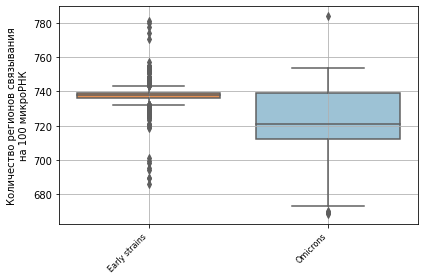

In [68]:
plot_df = count_df.loc[count_df["region"] == "RNA"].copy()
plot_df.index = plot_df["strain"]
plot_df = plot_df[["weighted count"]]

plot_df = plot_df.join(meta_df[["scorpio_call", "lineage", "group", "length"]], how="left")
plot_df.loc[plot_df["group"] == "first", "group"] = "Early strains"
plot_df.loc[plot_df["group"] == "second", "group"] = "Omicrons"
plot_df = plot_df.rename(columns={
    "scorpio_call": "Strain"
})

plot_df["weighted count"] = plot_df["weighted count"] * 30331 / plot_df["length"]

top = mpl.colormaps['Blues_r']
bottom = mpl.colormaps['Oranges']
colors = np.vstack((
    bottom(np.linspace(0.5, 0.8, 1)),
    top(np.linspace(0.6, 0.9, 1)),
))
cmap = ListedColormap(colors, name='OrangeBlue')

ax = sns.boxplot(
    y="weighted count",
    x="group",
    data=plot_df,
    palette=cmap.colors,
)

ax.set_xlabel("")
ax.set_ylabel("Количество регионов связывания\nна 100 микроРНК")

ax.set_yticks(
    [6.8, 7.0, 7.2, 7.4, 7.6, 7.8],
    [680, 700, 720, 740, 760, 780]
)

plt.xticks(
    fontsize=8,
    rotation=45,
    ha="right"
)

# ax.get_legend().remove()
plt.grid()
plt.tight_layout()
# plt.savefig("../../pictures/covid-weighted.png", dpi=500)

In [69]:
print(mannwhitneyu(
    plot_df.loc[plot_df["group"] == "Early strains", "weighted count"].to_list(),
    plot_df.loc[plot_df["group"] == "Omicrons", "weighted count"].to_list()
))

MannwhitneyuResult(statistic=2027385.0, pvalue=1.7648630379781022e-113)


In [70]:
# seed region distribution

In [71]:
seed_df = rdf.copy()
seed_df = seed_df.loc[STRAINS][MIMATS]

seed_df = seed_df.join(meta_df[["lineage", "length", "days", "group"]], how="left")

In [72]:
first_group = seed_df.loc[seed_df["group"] == "first"]
second_group = seed_df.loc[seed_df["group"] == "second"]

In [73]:
def extract(seeds):
    seeds = seeds.lstrip("[").rstrip("]").split(", ")
    seeds = list(map(int, [s for s in seeds if s]))
    return seeds

result_df = pd.DataFrame(columns=["group", "seed", "miRNA"])
for name, group in zip(("first", "second"), (first_group, second_group)):
    coords = []
    for mimat in tqdm.tqdm(MIMATS):
        expression = int(miRNA_df.loc[mimat]["CPM"] / TOTAL_EXPRESSION * 100)
        seeds = group[mimat].apply(lambda x: extract(x) * expression).to_list()
        append = []
        for s in seeds:
            append += s
        
        append_df = pd.DataFrame(columns=result_df.columns)
        append_df["seed"] = append
        append_df.loc[:, "group"] = name    
        result_df = pd.concat([result_df, append_df], ignore_index=True)
        
result_df.head()

100%|██████████| 32/32 [03:52<00:00,  7.25s/it]


,group,seed,miRNA
0,first,9860,NaN
1,first,12449,NaN
2,first,19060,NaN
3,first,9860,NaN
4,first,12449,NaN


/usr/local/lib/python3.8/dist-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


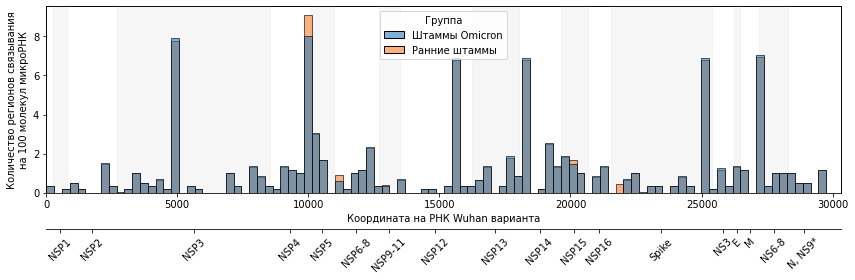

In [74]:
plot_df = result_df.copy()
plot_df.loc[plot_df["group"] == "first", "group"] = "Ранние штаммы"
plot_df.loc[plot_df["group"] == "second", "group"] = "Штаммы Omicron"
plot_df = plot_df.rename(columns={
    "group": "Группа"
})

fig, ax = plt.subplots(figsize=(12, 4))

ax.set_ylabel("Количество регионов связывания\nна 100 молекул микроРНК")
ax.set_xlabel("Координата на РНК Wuhan варианта") 
ax.set_xlim(0, 30330)

annotation = {
    "NSP1": "266-805",
    "NSP2": "806-2719",
    "NSP3": "2720-8554",
    "NSP4": "8555-10054",
    "NSP5": "10055-10972",
    # "NSP6": "10973-11842",
    # "NSP7": "11843-12091",
    # "NSP8": "12092-12685",
    "NSP6-8": "10973-12685",
    # "NSP9": "12686-13024",
    # "NSP10": "13025-13441",
    # "NSP11": "13442-13480",
    "NSP9-11": "12686-13480",
    # "NSP12": "13442-13468",
    "NSP12": "13468-16236",
    "NSP13": "16237-18039",
    "NSP14": "18040-19620",
    "NSP15": "19621-20658",
    "NSP16": "20659-21552",
    "Spike": "21563-25384",
    "NS3": "25393-26220",
    "E": "26245-26472",
    "M": "26523-27191",
    # "NS6": "27202-27387",
    # "NS7a": "27394-27759",
    # "NS7b": "27756-27887",
    # "NS8": "27894-28259",
    "NS6-8": "27202-28295",
    "N, NS9*": "28274-29533",
    # "NS9b": "28284-28577",
    # "NS9c": "28734-28955"
}

axsub = ax.twiny()
axsub.xaxis.set_ticks_position('bottom')
axsub.spines['bottom'].set_position(('outward', 36))

ticks = []
centers = []
proteins = []
for protein, region in annotation.items():
    start, end = map(int, region.split("-"))
    ticks.append(start - 1)
    ticks.append(end - 1)
    
    center = (start + end - 2) // 2
    centers.append(center)
    proteins.append(protein)

i = 0
while i < len(ticks):
    axsub.axvspan(ticks[i], ticks[i + 1], alpha=0.2, color="lightgrey")
    i += 4

top = mpl.colormaps['Blues_r']
bottom = mpl.colormaps['Oranges']
colors = np.vstack((
    top(np.linspace(0.3, 1, 1)),
    bottom(np.linspace(0.55, 1, 1))
))
cmap = ListedColormap(colors, name='OrangeBlue')
    
sns.histplot(
    x="seed",
    hue="Группа",
    hue_order=["Штаммы Omicron", "Ранние штаммы"],
    data=plot_df,
    stat="probability",
    common_norm=False,
    bins=100,
    palette=cmap.colors,
    alpha=0.6,
    ax=axsub
)

axsub.set_xlim(0, 30330)
    
axsub.set_xticks(
    centers,
    labels=proteins,
    rotation=45,
    ha="center"
)

axsub.set_xlabel("")

ax.set_yticks(
    [i / 100 for i in range(0, 9, 2)],
    labels=[i for i in range(0, 9, 2)]
)

plt.tight_layout()
# plt.savefig("../../pictures/seed-distribution-test.png", dpi=500)

In [75]:
# proteins contribution

In [77]:
result_df = pd.DataFrame(columns=[
    "region", "length",
    "first weighted", "second weighted",
    "first count", "second count",
    "p-value"
])

for protein in PROTEINS:
    if protein == "RNA":
        length = 30331
    else:
        length = list(map(int, ANNOTATION[protein].split("-")))
        length = length[1] - length[0] + 1
    
    df = count_df.loc[count_df["region"] == protein]
    df.index = df["strain"]
    df = df.join(meta_df[["group", "length"]], how="left")
    df = df.drop(columns=["strain"]).reset_index()
    
    first_group = df.loc[df["group"] == "first"][[
        "strain", "weighted count", "count"
    ]].groupby("strain").sum()
    second_group = df.loc[df["group"] == "second"][[
        "strain", "weighted count", "count"
    ]].groupby("strain").sum()
    
    try:
        stat, pv = mannwhitneyu(
            first_group["weighted count"],
            second_group["weighted count"]
        )
    except:
        pv = 1
        
    append_df = pd.DataFrame(
        columns=result_df.columns.to_list(),
        data=[[
            protein,
            length,
            first_group["weighted count"].mean(),
            second_group["weighted count"].mean(),
            first_group["count"].mean(),
            second_group["count"].mean(),
            pv
        ]]
    )
    
    result_df = pd.concat([result_df, append_df], ignore_index=True)

result_df["fdr"] = np.array(result_df["p-value"]) * len(result_df) / rankdata(result_df["p-value"])
result_df.loc[result_df["fdr"] > 1, "fdr"] = 1

In [78]:
result_df.sort_values(by=["first weighted"], ascending=False)

,region,length,first weighted,second weighted,first count,second count,p-value,fdr
29,RNA,30331,7.244055,7.111011,315.364784,312.775924,1.814988e-100,9.074939e-100
3,NSP3,5835,1.064485,1.070921,50.543269,51.645411,2.750542e-235,1.650325e-234
17,Spike,3822,0.863885,0.835003,43.309495,42.320620,1.568451e-53,6.721934e-53
4,NSP4,1500,0.857698,0.775302,21.983173,19.399881,7.410523e-246,5.557892e-245
14,NSP14,1581,0.750333,0.749476,22.020433,21.997616,3.938176e-04,8.438948e-04
12,NSP12,2769,0.521493,0.521570,10.993990,11.008939,1.838747e-01,2.903284e-01
21,NS6,186,0.414198,0.414166,0.999399,0.997616,7.467324e-01,8.616143e-01
13,NSP13,1803,0.399303,0.402221,30.954327,30.968415,4.351685e-05,1.004235e-04
15,NSP15,1038,0.337087,0.319151,19.978365,18.637068,0.000000e+00,0.000000e+00
5,NSP5,918,0.327397,0.327019,14.011418,14.002384,8.572361e-01,8.867960e-01


In [79]:
print_df = result_df.drop(columns=["first count", "second count", "p-value"])
print_df["first weighted"] *= 100
print_df["second weighted"] *= 100
print_df = print_df.loc[print_df["fdr"] < 0.05].sort_values(
    by=["fdr"]
)
for column in print_df.columns:
    print(f"& {column} ", end="")
print("\\\\")
print("\\hline")

for i, row in print_df.iterrows():
    for column in print_df.columns:
        if column == "fdr":
            print(f"& {float(row[column]):.4f} ", end="")
        elif column not in ["region", "length"]:
            print(f"& {float(row[column]):.2f} ", end="")
        else:
            print(f"& {row[column]} ", end="")
    print("\\\\")
    print("\\hline")

& region & length & first weighted & second weighted & fdr \\
\hline
& NSP15 & 1038 & 33.71 & 31.92 & 0.0000 \\
\hline
& N & 1260 & 19.32 & 19.56 & 0.0000 \\
\hline
& NS8 & 366 & 13.90 & 14.07 & 0.0000 \\
\hline
& NSP4 & 1500 & 85.77 & 77.53 & 0.0000 \\
\hline
& NSP3 & 5835 & 106.45 & 107.09 & 0.0000 \\
\hline
& RNA & 30331 & 724.41 & 711.10 & 0.0000 \\
\hline
& Spike & 3822 & 86.39 & 83.50 & 0.0000 \\
\hline
& 3P & 798 & 7.66 & 7.73 & 0.0000 \\
\hline
& NSP6 & 870 & 15.60 & 13.82 & 0.0000 \\
\hline
& NS3 & 828 & 12.40 & 12.86 & 0.0000 \\
\hline
& NSP9 & 339 & 5.83 & 5.35 & 0.0000 \\
\hline
& 5P & 265 & 2.50 & 2.40 & 0.0000 \\
\hline
& NSP13 & 1803 & 39.93 & 40.22 & 0.0001 \\
\hline
& NSP14 & 1581 & 75.03 & 74.95 & 0.0008 \\
\hline
& NS9b & 294 & 6.73 & 6.77 & 0.0022 \\
\hline
& E & 228 & 10.15 & 10.19 & 0.0028 \\
\hline
& NS9c & 222 & 7.25 & 7.30 & 0.0081 \\
\hline
& NSP10 & 417 & 2.11 & 2.12 & 0.0337 \\
\hline


In [80]:
print_df = result_df.drop(columns=["first count", "second count", "p-value"])
print_df["first weighted"] *= 100
print_df["second weighted"] *= 100
print_df = print_df.loc[print_df["fdr"] < 0.05].sort_values(
    by=["fdr"]
)
print(print_df)

   region length  first weighted  second weighted            fdr
15  NSP15   1038       33.708712        31.915124   0.000000e+00
25      N   1260       19.323164        19.561338   0.000000e+00
24    NS8    366       13.900770        14.073597  3.194675e-265
4    NSP4   1500       85.769845        77.530177  5.557892e-245
3    NSP3   5835      106.448470       107.092145  1.650325e-234
29    RNA  30331      724.405461       711.101120  9.074939e-100
17  Spike   3822       86.388482        83.500255   6.721934e-53
28     3P    798        7.662587         7.733193   1.999595e-36
6    NSP6    870       15.595297        13.824714   6.709149e-36
18    NS3    828       12.399691        12.855840   2.184663e-19
9    NSP9    339        5.826385         5.349609   1.469652e-17
0      5P    265        2.495007         2.397086   1.074171e-15
13  NSP13   1803       39.930336        40.222064   1.004235e-04
14  NSP14   1581       75.033272        74.947614   8.438948e-04
26   NS9b    294        6

In [81]:
result_df.loc[result_df["region"] != "RNA"][["first weighted", "second weighted"]].sum()

first weighted     7.383792
second weighted    7.251762
dtype: float64

In [82]:
result_df.loc[result_df["region"] == "RNA"][["first count", "second count"]].sum()

first count     315.364784
second count    312.775924
dtype: float64

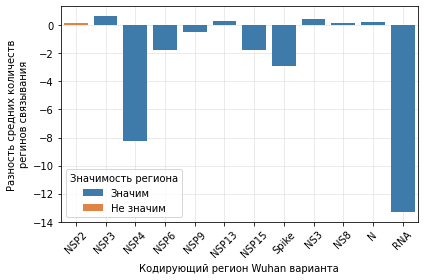

In [83]:
plot_df = result_df.copy()

plot_df["difference"] = (plot_df["second weighted"] - plot_df["first weighted"]) * 100
plot_df["fdr"] = np.array(plot_df["p-value"]) * len(plot_df) / rankdata(plot_df["p-value"])

plot_df["Значимость региона"] = "Не значим"
plot_df.loc[plot_df["fdr"] < 0.05, "Значимость региона"] = "Значим"

top = mpl.colormaps['Blues_r']
bottom = mpl.colormaps['Oranges']
colors = np.vstack((
    top(np.linspace(0.3, 1, 1)),
    bottom(np.linspace(0.55, 1, 1))
))
cmap = ListedColormap(colors, name='OrangeBlue')

ax = sns.barplot(
    x="region",
    y="difference",
    hue="Значимость региона",
    hue_order=["Значим", "Не значим"],
    data=plot_df.loc[np.abs(plot_df["difference"]) > 0.1],
    palette=cmap.colors,
    dodge=False
)

plt.xlabel("Кодирующий регион Wuhan варианта")
plt.ylabel("Разность средних количеств\nрегинов связывания")
ax.set_axisbelow(True)
plt.grid(alpha=0.3)
plt.xticks(
    rotation=45,
    ha="center"
)
plt.tight_layout()
# plt.savefig("../../pictures/mRNA-contribution.png", dpi=500)

# COAD analysis

In [84]:
# expressed miRNAs

In [85]:
miRNA_df = pd.read_csv("../../miRNA/expressed_COAD.csv", sep=",")
miRNA_df.index = miRNA_df["MIMAT"]

TOTAL_EXPRESSION = miRNA_df["CPM"].sum()
MIMATS = miRNA_df["MIMAT"].to_list()

In [86]:
mrdf = rdf.loc[STRAINS][MIMATS]
# mrdf["strain"] = mrdf.index

In [88]:
count_df = None

for protein in tqdm.tqdm(PROTEINS):
    df = mrdf.copy()    
    df["region"] = [protein] * len(df)
        
    if protein != "RNA":
        s, e = map(lambda x: int(x) - 1, ANNOTATION[protein].split("-"))
    else:
        s, e = None, None

    for mimat in MIMATS:
        df[mimat] = df[mimat].apply(lambda x: region_count(x, s, e))

    if count_df is None:
        count_df = df
    else:
        count_df = pd.concat([count_df, df], ignore_index=True)

count_df.loc[:, "count"] = 0
count_df.loc[:, "weighted count"] = 0
for mimat in tqdm.tqdm(MIMATS):
    expression = (miRNA_df.loc[mimat, "CPM"] / TOTAL_EXPRESSION)
    count_df["count"] += count_df[mimat]
    count_df["weighted count"] += count_df[mimat] * expression

100%|██████████| 40/40 [00:00<00:00, 94.20it/s] 


In [89]:
wcount_df = pd.read_csv("../../results/wuhan/seed.csv", sep=";", index_col=0)

for mimat in MIMATS:
    wcount_df[mimat] = wcount_df[mimat].apply(lambda x: region_count(x))
    
wcount_df.loc[:, "count"] = 0
wcount_df.loc[:, "weighted count"] = 0
for mimat in tqdm.tqdm(MIMATS):
    expression = (miRNA_df.loc[mimat, "CPM"] / TOTAL_EXPRESSION)
    wcount_df["count"] += wcount_df[mimat]
    wcount_df["weighted count"] += wcount_df[mimat] * expression

100%|██████████| 40/40 [00:00<00:00, 466.08it/s]


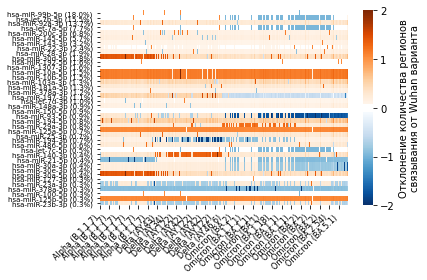

In [90]:
plot_df = count_df.loc[count_df["region"] == "RNA"].copy()

plot_df.index = plot_df["strain"]
plot_df = plot_df[MIMATS]
plot_df = plot_df.join(meta_df[["scorpio_call", "lineage", "length"]], how="left")

for mimat in MIMATS:
    plot_df[mimat] = np.array(plot_df[mimat], dtype=np.float64) * \
        (30331 / np.array(plot_df["length"], dtype=np.float64)) - \
        np.array(wcount_df[mimat], dtype=np.float64)

plot_df["strain"] = plot_df["scorpio_call"].str.split("(").str[0] + "(" + \
    plot_df["lineage"] + ")"
plot_df.index = plot_df["strain"]
plot_df = plot_df[MIMATS]

plot_df = plot_df.transpose()

miRNA_df.index = miRNA_df["MIMAT"]
plot_df = plot_df.join(miRNA_df[["miRNA", "CPM"]], how="left").sort_values(by="CPM", ascending=False)
plot_df.index = plot_df["miRNA"]
plot_df = plot_df.drop(columns=["miRNA", "CPM"])

plot_df["index"] = plot_df.index
miRNA_df.index = miRNA_df["miRNA"]
plot_df["index"] = plot_df["index"].apply(lambda x: f"{x} ({miRNA_df.loc[x]['CPM'] / miRNA_df['CPM'].sum() * 100:.1f}%)")
miRNA_df.index = miRNA_df["MIMAT"]
plot_df.index = plot_df["index"]
plot_df = plot_df.drop(columns=["index"])

bottom = mpl.colormaps['Oranges']
top = mpl.colormaps['Blues_r']
colors = np.vstack((
    top(np.linspace(0, 1, 128)),
    [[0, 0, 0, 0]] * 10,
    bottom(np.linspace(0, 1, 128))
))
cmap = ListedColormap(colors, name='OrangeBlue')

sns.heatmap(
    plot_df,
    cmap=cmap,
    vmin=-2,
    vmax=2,
    # linewidths=1,
    # linecolor="white",
    cbar_kws={
        "ticks": [-2, -1, 0, 1, 2],
        "label": "Отклонение количества регионов\nсвязывания от Wuhan варианта"
    }
)

plt.yticks(
    [0.5 + i for i in range(len(plot_df))],
    labels=plot_df.index.to_list(),
    fontsize=7
)
plt.ylabel("")

plt.xticks(
    fontsize=8,
    rotation=45,
    ha="right"
)

plt.tight_layout()
# plt.savefig("../../pictures/miRNA-covid.png", dpi=500)

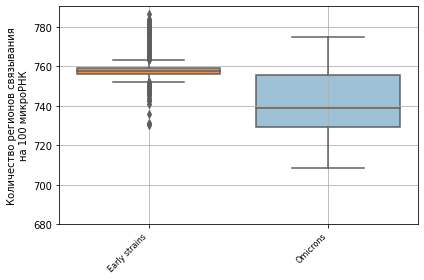

In [91]:
plot_df = count_df.loc[count_df["region"] == "RNA"].copy()
plot_df.index = plot_df["strain"]
plot_df = plot_df[["weighted count"]]

plot_df = plot_df.join(meta_df[["scorpio_call", "lineage", "group", "length"]], how="left")
plot_df.loc[plot_df["group"] == "first", "group"] = "Early strains"
plot_df.loc[plot_df["group"] == "second", "group"] = "Omicrons"
plot_df = plot_df.rename(columns={
    "scorpio_call": "Strain"
})

plot_df["weighted count"] = plot_df["weighted count"] * 30331 / plot_df["length"]

top = mpl.colormaps['Blues_r']
bottom = mpl.colormaps['Oranges']
colors = np.vstack((
    bottom(np.linspace(0.5, 0.8, 1)),
    top(np.linspace(0.6, 0.9, 1)),
))
cmap = ListedColormap(colors, name='OrangeBlue')

ax = sns.boxplot(
    y="weighted count",
    x="group",
    data=plot_df,
    palette=cmap.colors,
)

ax.set_xlabel("")
ax.set_ylabel("Количество регионов связывания\nна 100 микроРНК")

ax.set_yticks(
    [6.8, 7.0, 7.2, 7.4, 7.6, 7.8],
    [680, 700, 720, 740, 760, 780]
)

plt.xticks(
    fontsize=8,
    rotation=45,
    ha="right"
)

# ax.get_legend().remove()
plt.grid()
plt.tight_layout()
# plt.savefig("../../pictures/covid-weighted.png", dpi=500)

In [92]:
print(mannwhitneyu(
    plot_df.loc[plot_df["group"] == "Early strains", "weighted count"].to_list(),
    plot_df.loc[plot_df["group"] == "Omicrons", "weighted count"].to_list()
))

MannwhitneyuResult(statistic=2453380.0, pvalue=0.0)


In [93]:
# seed region distribution

In [94]:
seed_df = rdf.copy()
seed_df = seed_df.loc[STRAINS][MIMATS]

seed_df = seed_df.join(meta_df[["lineage", "length", "days", "group"]], how="left")

In [95]:
first_group = seed_df.loc[seed_df["group"] == "first"]
second_group = seed_df.loc[seed_df["group"] == "second"]

In [96]:
def extract(seeds):
    seeds = seeds.lstrip("[").rstrip("]").split(", ")
    seeds = list(map(int, [s for s in seeds if s]))
    return seeds

result_df = pd.DataFrame(columns=["group", "seed", "miRNA"])
for name, group in zip(("first", "second"), (first_group, second_group)):
    coords = []
    for mimat in tqdm.tqdm(MIMATS):
        expression = int(miRNA_df.loc[mimat]["CPM"] / TOTAL_EXPRESSION * 100)
        seeds = group[mimat].apply(lambda x: extract(x) * expression).to_list()
        append = []
        for s in seeds:
            append += s
        
        append_df = pd.DataFrame(columns=result_df.columns)
        append_df["seed"] = append
        append_df.loc[:, "group"] = name    
        result_df = pd.concat([result_df, append_df], ignore_index=True)
        
result_df.head()

100%|██████████| 40/40 [03:55<00:00,  5.88s/it]


,group,seed,miRNA
0,first,9860,NaN
1,first,12449,NaN
2,first,19060,NaN
3,first,9860,NaN
4,first,12449,NaN


/usr/local/lib/python3.8/dist-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


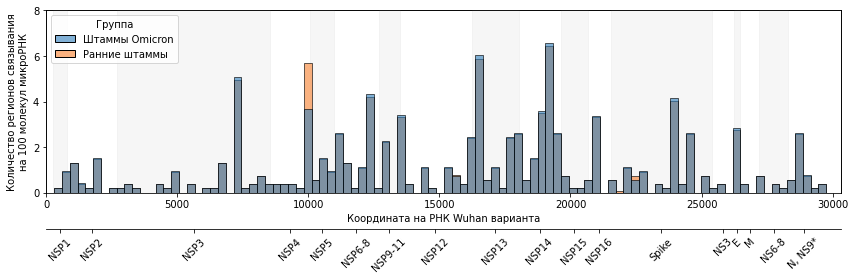

In [97]:
plot_df = result_df.copy()
plot_df.loc[plot_df["group"] == "first", "group"] = "Ранние штаммы"
plot_df.loc[plot_df["group"] == "second", "group"] = "Штаммы Omicron"
plot_df = plot_df.rename(columns={
    "group": "Группа"
})

fig, ax = plt.subplots(figsize=(12, 4))

ax.set_ylabel("Количество регионов связывания\nна 100 молекул микроРНК")
ax.set_xlabel("Координата на РНК Wuhan варианта") 
ax.set_xlim(0, 30330)

annotation = {
    "NSP1": "266-805",
    "NSP2": "806-2719",
    "NSP3": "2720-8554",
    "NSP4": "8555-10054",
    "NSP5": "10055-10972",
    # "NSP6": "10973-11842",
    # "NSP7": "11843-12091",
    # "NSP8": "12092-12685",
    "NSP6-8": "10973-12685",
    # "NSP9": "12686-13024",
    # "NSP10": "13025-13441",
    # "NSP11": "13442-13480",
    "NSP9-11": "12686-13480",
    # "NSP12": "13442-13468",
    "NSP12": "13468-16236",
    "NSP13": "16237-18039",
    "NSP14": "18040-19620",
    "NSP15": "19621-20658",
    "NSP16": "20659-21552",
    "Spike": "21563-25384",
    "NS3": "25393-26220",
    "E": "26245-26472",
    "M": "26523-27191",
    # "NS6": "27202-27387",
    # "NS7a": "27394-27759",
    # "NS7b": "27756-27887",
    # "NS8": "27894-28259",
    "NS6-8": "27202-28295",
    "N, NS9*": "28274-29533",
    # "NS9b": "28284-28577",
    # "NS9c": "28734-28955"
}

axsub = ax.twiny()
axsub.xaxis.set_ticks_position('bottom')
axsub.spines['bottom'].set_position(('outward', 36))

ticks = []
centers = []
proteins = []
for protein, region in annotation.items():
    start, end = map(int, region.split("-"))
    ticks.append(start - 1)
    ticks.append(end - 1)
    
    center = (start + end - 2) // 2
    centers.append(center)
    proteins.append(protein)

i = 0
while i < len(ticks):
    axsub.axvspan(ticks[i], ticks[i + 1], alpha=0.2, color="lightgrey")
    i += 4

top = mpl.colormaps['Blues_r']
bottom = mpl.colormaps['Oranges']
colors = np.vstack((
    top(np.linspace(0.3, 1, 1)),
    bottom(np.linspace(0.55, 1, 1))
))
cmap = ListedColormap(colors, name='OrangeBlue')
    
sns.histplot(
    x="seed",
    hue="Группа",
    hue_order=["Штаммы Omicron", "Ранние штаммы"],
    data=plot_df,
    stat="probability",
    common_norm=False,
    bins=100,
    palette=cmap.colors,
    alpha=0.6,
    ax=axsub
)

axsub.set_xlim(0, 30330)
    
axsub.set_xticks(
    centers,
    labels=proteins,
    rotation=45,
    ha="center"
)

axsub.set_xlabel("")

ax.set_yticks(
    [i / 100 for i in range(0, 9, 2)],
    labels=[i for i in range(0, 9, 2)]
)

plt.tight_layout()
# plt.savefig("../../pictures/seed-distribution-test.png", dpi=500)

In [98]:
# proteins contribution

In [99]:
result_df = pd.DataFrame(columns=[
    "region", "length",
    "first weighted", "second weighted",
    "first count", "second count",
    "p-value"
])

for protein in PROTEINS:
    if protein == "RNA":
        length = 30331
    else:
        length = list(map(int, ANNOTATION[protein].split("-")))
        length = length[1] - length[0] + 1
    
    df = count_df.loc[count_df["region"] == protein]
    df.index = df["strain"]
    df = df.join(meta_df[["group", "length"]], how="left")
    df = df.drop(columns=["strain"]).reset_index()
    
    first_group = df.loc[df["group"] == "first"][[
        "strain", "weighted count", "count"
    ]].groupby("strain").sum()
    second_group = df.loc[df["group"] == "second"][[
        "strain", "weighted count", "count"
    ]].groupby("strain").sum()
    
    try:
        stat, pv = mannwhitneyu(
            first_group["weighted count"],
            second_group["weighted count"]
        )
    except:
        pv = 1
        
    append_df = pd.DataFrame(
        columns=result_df.columns.to_list(),
        data=[[
            protein,
            length,
            first_group["weighted count"].mean(),
            second_group["weighted count"].mean(),
            first_group["count"].mean(),
            second_group["count"].mean(),
            pv
        ]]
    )
    
    result_df = pd.concat([result_df, append_df], ignore_index=True)

result_df["fdr"] = np.array(result_df["p-value"]) * len(result_df) / rankdata(result_df["p-value"])
result_df.loc[result_df["fdr"] > 1, "fdr"] = 1

In [100]:
result_df.sort_values(by=["first weighted"], ascending=False)

,region,length,first weighted,second weighted,first count,second count,p-value,fdr
29,RNA,30331,7.444022,7.286030,386.899639,381.269964,0.000000e+00,0.000000e+00
13,NSP13,1803,1.000289,1.000190,36.959736,36.960667,7.930971e-04,1.982743e-03
14,NSP14,1581,0.941694,0.940494,29.006010,28.997616,2.351575e-01,3.527362e-01
3,NSP3,5835,0.913035,0.910535,65.894832,65.653754,1.506718e-46,9.040307e-46
17,Spike,3822,0.906779,0.880371,55.599760,52.999404,0.000000e+00,0.000000e+00
4,NSP4,1500,0.483055,0.359973,18.992188,17.441597,1.123721e-245,8.427907e-245
6,NSP6,870,0.338344,0.338637,17.530649,17.311681,5.271715e-04,1.437741e-03
12,NSP12,2769,0.329847,0.327794,23.020433,22.948749,7.926922e-13,2.642307e-12
16,NSP16,894,0.306326,0.305675,14.004207,13.993445,1.093277e-01,1.726227e-01
2,NSP2,1914,0.291321,0.292005,21.030048,21.043504,8.542116e-01,8.542116e-01


In [101]:
print_df = result_df.drop(columns=["first count", "second count", "p-value"])
print_df["first weighted"] *= 100
print_df["second weighted"] *= 100
print_df = print_df.loc[print_df["fdr"] < 0.05].sort_values(
    by=["fdr"]
)
for column in print_df.columns:
    print(f"& {column} ", end="")
print("\\\\")
print("\\hline")

for i, row in print_df.iterrows():
    for column in print_df.columns:
        if column == "fdr":
            print(f"& {float(row[column]):.4f} ", end="")
        elif column not in ["region", "length"]:
            print(f"& {float(row[column]):.2f} ", end="")
        else:
            print(f"& {row[column]} ", end="")
    print("\\\\")
    print("\\hline")

& region & length & first weighted & second weighted & fdr \\
\hline
& NSP15 & 1038 & 13.07 & 12.58 & 0.0000 \\
\hline
& Spike & 3822 & 90.68 & 88.04 & 0.0000 \\
\hline
& RNA & 30331 & 744.40 & 728.60 & 0.0000 \\
\hline
& NSP4 & 1500 & 48.31 & 36.00 & 0.0000 \\
\hline
& NSP3 & 5835 & 91.30 & 91.05 & 0.0000 \\
\hline
& 3P & 798 & 2.34 & 2.44 & 0.0000 \\
\hline
& NS3 & 828 & 6.74 & 6.84 & 0.0000 \\
\hline
& NSP9 & 339 & 17.22 & 17.14 & 0.0000 \\
\hline
& NSP12 & 2769 & 32.98 & 32.78 & 0.0000 \\
\hline
& NSP1 & 540 & 8.99 & 9.11 & 0.0001 \\
\hline
& NSP6 & 870 & 33.83 & 33.86 & 0.0014 \\
\hline
& NSP13 & 1803 & 100.03 & 100.02 & 0.0020 \\
\hline
& NS9c & 222 & 18.37 & 18.42 & 0.0060 \\
\hline
& E & 228 & 17.83 & 17.85 & 0.0238 \\
\hline


In [102]:
print_df = result_df.drop(columns=["first count", "second count", "p-value"])
print_df["first weighted"] *= 100
print_df["second weighted"] *= 100
print_df = print_df.loc[print_df["fdr"] < 0.05].sort_values(
    by=["fdr"]
)
print(print_df)

   region length  first weighted  second weighted            fdr
15  NSP15   1038       13.067516        12.577074   0.000000e+00
17  Spike   3822       90.677926        88.037097   0.000000e+00
29    RNA  30331      744.402165       728.602971   0.000000e+00
4    NSP4   1500       48.305460        35.997321  8.427907e-245
3    NSP3   5835       91.303517        91.053545   9.040307e-46
28     3P    798        2.339886         2.443671   1.414756e-29
18    NS3    828        6.741988         6.840574   1.046132e-23
9    NSP9    339       17.220662        17.142303   1.249010e-16
12  NSP12   2769       32.984747        32.779356   2.642307e-12
1    NSP1    540        8.993058         9.114966   9.609457e-05
6    NSP6    870       33.834385        33.863748   1.437741e-03
13  NSP13   1803      100.028889       100.018951   1.982743e-03
27   NS9c    222       18.367030        18.417426   6.016911e-03
19      E    228       17.831659        17.845679   2.377449e-02


In [103]:
result_df.loc[result_df["region"] != "RNA"][["first weighted", "second weighted"]].sum()

first weighted     7.671332
second weighted    7.514052
dtype: float64

In [104]:
result_df.loc[result_df["region"] == "RNA"][["first count", "second count"]].sum()

first count     386.899639
second count    381.269964
dtype: float64

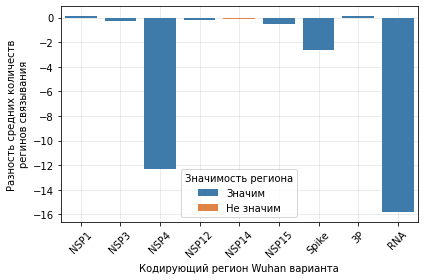

In [105]:
plot_df = result_df.copy()

plot_df["difference"] = (plot_df["second weighted"] - plot_df["first weighted"]) * 100
plot_df["fdr"] = np.array(plot_df["p-value"]) * len(plot_df) / rankdata(plot_df["p-value"])

plot_df["Значимость региона"] = "Не значим"
plot_df.loc[plot_df["fdr"] < 0.05, "Значимость региона"] = "Значим"

top = mpl.colormaps['Blues_r']
bottom = mpl.colormaps['Oranges']
colors = np.vstack((
    top(np.linspace(0.3, 1, 1)),
    bottom(np.linspace(0.55, 1, 1))
))
cmap = ListedColormap(colors, name='OrangeBlue')

ax = sns.barplot(
    x="region",
    y="difference",
    hue="Значимость региона",
    hue_order=["Значим", "Не значим"],
    data=plot_df.loc[np.abs(plot_df["difference"]) > 0.1],
    palette=cmap.colors,
    dodge=False
)

plt.xlabel("Кодирующий регион Wuhan варианта")
plt.ylabel("Разность средних количеств\nрегинов связывания")
ax.set_axisbelow(True)
plt.grid(alpha=0.3)
plt.xticks(
    rotation=45,
    ha="center"
)
plt.tight_layout()
# plt.savefig("../../pictures/mRNA-contribution.png", dpi=500)